In [197]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [198]:
data = pd.read_csv('train.csv', index_col='id')

In [199]:
data.count()

playtime_forever          357
is_free                   357
price                     357
genres                    357
categories                357
tags                      357
purchase_date             355
release_date              357
total_positive_reviews    355
total_negative_reviews    355
dtype: int64

In [200]:
data.head(10)

,playtime_forever,is_free,price,genres,categories,tags,purchase_date,release_date,total_positive_reviews,total_negative_reviews
id,,,,,,,,,,
0,0.000000,False,3700.0,"Adventure,Casual,Indie","Single-player,Steam Trading Cards,Steam Cloud","Indie,Adventure,Story Rich,Casual,Atmospheric,...","Jul 2, 2018","10 Dec, 2013",372.0,96.0
1,0.016667,True,0.0,RPG,"Single-player,Partial Controller Support","Mod,Utilities,RPG,Game Development,Singleplaye...","Nov 26, 2016","12 Aug, 2015",23.0,0.0
2,0.000000,False,5000.0,"Adventure,Casual,Indie","Single-player,Full controller support,Steam Tr...","Point & Click,Adventure,Story Rich,Comedy,Indi...","Jul 2, 2018","28 Jan, 2014",3018.0,663.0
3,1.533333,False,9900.0,"Action,RPG","Single-player,Multi-player,Steam Achievements,...","Medieval,RPG,Open World,Strategy,Sandbox,Actio...","Nov 28, 2016","31 Mar, 2010",63078.0,1746.0
4,22.333333,False,4800.0,"Action,Indie,Strategy","Single-player,Co-op,Steam Achievements,Full co...","Tower Defense,Co-op,Action,Strategy,Online Co-...","Mar 4, 2018","30 Jul, 2012",8841.0,523.0
5,2.933333,False,25800.0,RPG,"Single-player,Online Co-op,Local Co-op,Shared/...","RPG,Open World,Survival,Co-op,Fantasy,Online C...",NaN,"26 Mar, 2019",NaN,NaN
6,2.616667,False,3600.0,"Action,Indie","Single-player,Steam Achievements,Steam Trading...","Great Soundtrack,Action,Violent,Indie,Top-Down...","Feb 16, 2018","23 Oct, 2012",39776.0,1035.0
7,0.150000,True,0.0,Simulation,"Single-player,Multi-player,Online Multi-Player...","VR,Simulation,Utilities,Multiplayer","Jan 29, 2018","28 Apr, 2016",33.0,3.0
8,0.016667,False,4000.0,"Adventure,RPG","Single-player,Steam Achievements,Steam Trading...","RPG,Turn-Based,Adventure,Fantasy,Great Soundtr...","Nov 23, 2018","25 Feb, 2014",1875.0,39.0


## Data preprocessing
playtime_forever: output\
is_free: boolean => map 0/1\
price: discrete number => scaling\
genres: string => split and dummy (pivot)\
categories: stirng => split and dummy (pivot)\
tags: string => count its numbers of letter and catogorize\
purchase_date, release_date: date => convert to stamptime and count the differece bewteen them as well as now\
total_positive_reviews: float => scaling\
total_negative_reviews: float => scaling

In [201]:
# is_free: boolean => map 0/1
data['is_free'] = data['is_free'].map({False:0, True:1})

In [202]:
# price: discrete number => scaling
data['price'].nlargest(5)

id
220    15999900.0
312     6999900.0
133       30800.0
91        29900.0
140       26800.0
Name: price, dtype: float64

In [203]:
# Top 2 is way larger and may have negative effect to the whole dataset. So will be removed.
data = data.drop(data['price'].nlargest(2).index)

In [204]:
data['price'].describe()

count      355.000000
mean      6845.912676
std       5067.323386
min          0.000000
25%       3600.000000
50%       6800.000000
75%       9000.000000
max      30800.000000
Name: price, dtype: float64

In [205]:
# It doesn't meet the std. So we scale it by MinMaxScaler
price_scaler = MinMaxScaler()
price_scaler.fit(data['price'].values.reshape(-1,1))
price_scaled = price_scaler.fit_transform(data['price'].values.reshape(-1,1))

In [206]:
data['price'] = price_scaled

In [207]:
# genres: string => split and dummy (pivot)
data['genres'].isna().sum()

0

In [208]:
genres_split = data['genres'].apply(lambda x: x.strip().split(","))

In [209]:
genres = pd.get_dummies(genres_split.apply(pd.Series).stack()).sum(level=0)

In [210]:
genres.columns = pd.MultiIndex.from_product([['genres'], genres.columns])

In [211]:
data = data.drop(columns=['genres'])

In [212]:
data = pd.concat([data, genres], axis=1)

In [213]:
# categories: stirng => split and dummy (pivot)
data['categories'].isna().sum()

0

In [214]:
categories_split = data['categories'].apply(lambda x: x.strip().split(","))
categories = pd.get_dummies(categories_split.apply(pd.Series).stack()).sum(level=0)
categories.columns = pd.MultiIndex.from_product([['categories'], categories.columns])
data = data.drop(columns=['categories'])
data = pd.concat([data, categories], axis=1)

In [215]:
# tags: string => count its numbers of letter and catogorize
data['tags'].isna().sum()

0

In [216]:
data['tags'] = data['tags'].apply(len)

In [217]:
data['tags'].describe()

count    355.000000
mean     179.230986
std       52.983769
min        8.000000
25%      170.000000
50%      197.000000
75%      213.000000
max      255.000000
Name: tags, dtype: float64

In [218]:
data.loc[data['tags'] <= 170, 'tags'] = 0
data.loc[(data['tags'] > 170) & (data['tags'] <= 197), 'tags'] = 0.25
data.loc[(data['tags'] > 197) & (data['tags'] <= 213), 'tags'] = 0.5
data.loc[data['tags'] > 213, 'tags'] = 1

In [219]:
# purchase_date, release_date: date => convert to stamptime and count the differece bewteen them as well as now
data['purchase_date'].isna().sum()

2

In [220]:
# Drop the examples with NaN value
data = data.drop(data.loc[data['purchase_date'].isna(), :].index)

In [221]:
data['purchase_date'] = data['purchase_date'].apply(lambda x: datetime.strptime(x, '%b %d, %Y'))

In [222]:
data['release_date'].isna().sum()

0

In [223]:
data.loc[data['release_date'] == 'Nov 10, 2016', 'release_date'] = '10 Nov, 2016' # Exception 

In [224]:
data['release_date'] = data['release_date'].apply(lambda x: datetime.strptime(x, '%d %b, %Y'))

In [225]:
data['day_btn_purchase_release'] = (data['purchase_date'] - data['release_date']).dt.days

In [226]:
data['day_btn_2020_purchase'] = (datetime(2020,1,1)-data['purchase_date']).dt.days

In [227]:
# scaling day
data['day_btn_purchase_release'].max()

4320

In [228]:
data['day_btn_purchase_release'].min()

-481

In [229]:
# data['day_btn_purchase_release'] divided by 5000
data['day_btn_purchase_release'] = data['day_btn_purchase_release'] / 5000

In [230]:
data['day_btn_2020_purchase'].max()

1612

In [231]:
data['day_btn_2020_purchase'].min()

116

In [232]:
# data['day_btn_2020_purchase'] divided by 2000
data['day_btn_2020_purchase'] = data['day_btn_2020_purchase'] / 2000

In [233]:
# Remove purchase_date and release_date
data = data.drop(columns=['purchase_date', 'release_date'])

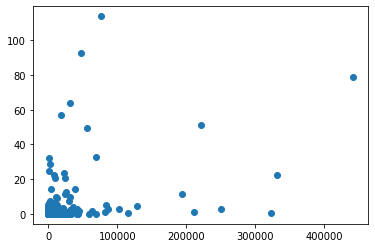

In [234]:
# Inspect the correlation bewteen the play time and positive comment
plt.scatter(x=data['total_positive_reviews'], y=data['playtime_forever'])

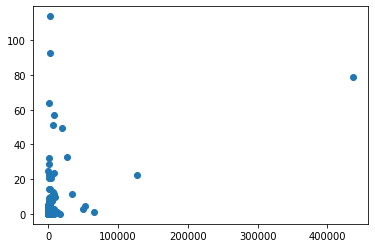

In [235]:
plt.scatter(x=data['total_negative_reviews'], y=data['playtime_forever'])

In [236]:
# So just scalling
data['total_positive_reviews'].max()

440902.0

In [237]:
# Divided by 100000
data['total_positive_reviews'] = data['total_positive_reviews'] / 100000

In [238]:
data['total_negative_reviews'].max()

436046.0

In [239]:
# Divided by 100000
data['total_negative_reviews'] = data['total_negative_reviews'] / 100000

In [240]:
# Save the prepocsssing data
data.to_csv('prepocessed_data.csv')

## Data split

In [241]:
X = data.drop(columns=['playtime_forever'])
y = data['playtime_forever']

In [242]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

## Train Model

In [243]:
svr = svm.SVR()
svr.fit(X_train, y_train) 

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [244]:
mlp = MLPRegressor(batch_size=2, max_iter=10000)
mlp.fit(X_train, y_train) 

MLPRegressor(activation='relu', alpha=0.0001, batch_size=2, beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_iter=10000, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [245]:
ada = AdaBoostRegressor(random_state=0, n_estimators=100)
ada.fit(X_train, y_train)  

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=100, random_state=0)

In [256]:
rdf = RandomForestRegressor()
rdf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [247]:
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [248]:
xgb = XGBRegressor(n_estimators=1000, learning_rate=0.1)
xgb.fit(X_train, y_train)

[14:45:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

## Evaluate the models

In [249]:
np.sqrt(mean_squared_error(svr.predict(X_test), y_test))

2.4830390685830945

In [250]:
np.sqrt(mean_squared_error(mlp.predict(X_test), y_test))

9.418760435256234

In [251]:
np.sqrt(mean_squared_error(ada.predict(X_test), y_test))

8.157201778785913

In [257]:
np.sqrt(mean_squared_error(rdf.predict(X_test), y_test))

4.6195742197979905

In [253]:
np.sqrt(mean_squared_error(knn.predict(X_test), y_test))

3.640029719387562

In [254]:
np.sqrt(mean_squared_error(xgb.predict(X_test), y_test))

4.831834594465328

In [189]:
vonderland_xgb = XGBRegressor(n_estimators=100,
                    learning_rate = .01,
                    max_depth = 4,
                    random_state=42,
                    n_jobs = -1,
                    early_stopping_rounds=10)
vonderland_xgb.fit(X_train, y_train)
np.sqrt(mean_squared_error(vonderland_xgb.predict(X_test), y_test))

[14:39:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


5.26200658665984

In [190]:
vonderland_rdf = RandomForestRegressor(n_estimators=60, oob_score=True, random_state=1)
vonderland_rdf.fit(X_train, y_train)
np.sqrt(mean_squared_error(vonderland_rdf.predict(X_test), y_test))

5.020242717084808

## Cross Validation

In [255]:
-1 * cross_val_score(svr, X, y,
                              cv=5,
                              scoring='neg_mean_squared_error').mean()

132.80108822024388

In [191]:
-1 * cross_val_score(vonderland_xgb, X, y,
                              cv=5,
                              scoring='neg_mean_squared_error').mean()

[14:39:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:39:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:39:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:39:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:39:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


129.24490775103007

In [192]:
-1 * cross_val_score(vonderland_rdf, X, y,
                              cv=5,
                              scoring='neg_mean_squared_error').mean()

124.5117565287807

In [193]:
-1 * cross_val_score(xgb, X, y,
                              cv=5,
                              scoring='neg_mean_squared_error').mean()

[14:39:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:39:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:40:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:40:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:40:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


139.08270166123356

In [272]:
rdf = RandomForestRegressor()
-1 * cross_val_score(rdf, X, y,
                              cv=10,
                              scoring='neg_mean_squared_error').mean()

151.66805365299825

In [273]:
rdf = RandomForestRegressor(n_estimators=56)
-1 * cross_val_score(rdf, X, y,
                              cv=10,
                              scoring='neg_mean_squared_error').mean()

132.06268981804152

In [276]:
rdf = RandomForestRegressor(n_estimators=56,)
-1 * cross_val_score(rdf, X, y,
                              cv=10,
                              scoring='neg_mean_squared_error').mean()

133.06547460898486

## Hyperparameter tuning

In [324]:
# Random forest

In [286]:
from sklearn.model_selection import RandomizedSearchCV# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 56, stop = 1120, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rdf = RandomForestRegressor()
rdf_random = RandomizedSearchCV(estimator = rdf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rdf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.1min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [287]:
rdf_random.best_params_

{'n_estimators': 174,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 90,
 'bootstrap': True}

In [288]:
rdf = RandomForestRegressor(n_estimators=174, 
                            min_samples_split=10,
                            min_samples_leaf=4,
                            max_features='sqrt', 
                            max_depth=90, 
                            bootstrap=True)
-1 * cross_val_score(rdf, X, y,
                              cv=10,
                              scoring='neg_mean_squared_error').mean()

109.38248676330404

In [378]:
# XGBoost
from sklearn.model_selection import RandomizedSearchCV# Number of trees in random forest

random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1000, num = 100)],
               'learning_rate': [0.1, 0.01, 0.001],
               'max_depth': [3,4,5],
               'objective': ['reg:squarederror'],
               }
xgb = XGBRegressor()
xgb_random = RandomizedSearchCV(estimator = xgb, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
xgb_random.fit(X, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.7min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_st...
                   iid='warn', n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.01, 0.001],
                                        'max_depth': [3, 4

In [379]:
xgb_random.best_params_

{'objective': 'reg:squarederror',
 'n_estimators': 609,
 'max_depth': 4,
 'learning_rate': 0.001}

In [380]:
xgb = XGBRegressor(n_estimators=609, objective='reg:squarederror', max_depth=4, learning_rate=0.001)
-1 * cross_val_score(xgb, X, y,
                              cv=10,
                              scoring='neg_mean_squared_error').mean()

123.83482776905173

In [76]:
data.shape

(353, 57)

In [77]:
test_data = pd.read_csv('test.csv', index_col='id')

## Data preprocessing for test data
playtime_forever: output\
is_free: boolean => map 0/1\
price: discrete number => scaling\
genres: string => split and dummy (pivot)\
categories: stirng => split and dummy (pivot)\
tags: string => count its numbers of letter and catogorize\
purchase_date, release_date: date => convert to stamptime and count the differece bewteen them as well as now\
total_positive_reviews: float => scaling\
total_negative_reviews: float => scaling

In [79]:
# is_free: boolean => map 0/1
test_data['is_free'] = test_data['is_free'].map({False:0, True:1})

In [80]:
# price: discrete number => scaling
test_data['price'] = test_data['price'] / 30800

In [81]:
# genres: string => split and dummy (pivot)
genres_split = test_data['genres'].apply(lambda x: x.strip().split(","))
genres = pd.get_dummies(genres_split.apply(pd.Series).stack()).sum(level=0)
genres.columns = pd.MultiIndex.from_product([['genres'], genres.columns])
test_data = test_data.drop(columns=['genres'])
test_data = pd.concat([test_data, genres], axis=1)

In [82]:
# categories: stirng => split and dummy (pivot)
categories_split = test_data['categories'].apply(lambda x: x.strip().split(","))
categories = pd.get_dummies(categories_split.apply(pd.Series).stack()).sum(level=0)
categories.columns = pd.MultiIndex.from_product([['categories'], categories.columns])
test_data = test_data.drop(columns=['categories'])
test_data = pd.concat([test_data, categories], axis=1)

In [83]:
# tags: string => count its numbers of letter and catogorize
test_data['tags'] = test_data['tags'].apply(len)
test_data.loc[test_data['tags'] <= 170, 'tags'] = 0
test_data.loc[(test_data['tags'] > 170) & (test_data['tags'] <= 197), 'tags'] = 1
test_data.loc[(test_data['tags'] > 197) & (test_data['tags'] <= 213), 'tags'] = 2
test_data.loc[test_data['tags'] > 213, 'tags'] = 3

In [84]:
# purchase_date, release_date: date => convert to stamptime and count the differece bewteen them as well as now
test_data['purchase_date'] = test_data['purchase_date'].fillna("Sep 2, 2019")
test_data['purchase_date'] = test_data['purchase_date'].apply(lambda x: datetime.strptime(x, '%b %d, %Y'))
test_data['release_date'] = test_data['release_date'].apply(lambda x: datetime.strptime(x, '%d-%b-%y'))
test_data['day_btn_purchase_release'] = (test_data['purchase_date'] - test_data['release_date']).dt.days
test_data['day_btn_2020_purchase'] = (datetime(2020,1,1)-test_data['purchase_date']).dt.days
test_data['day_btn_purchase_release'] = test_data['day_btn_purchase_release'] / 5000
test_data['day_btn_2020_purchase'] = test_data['day_btn_2020_purchase'] / 2000
test_data = test_data.drop(columns=['purchase_date', 'release_date'])

In [85]:
# total_positive_reviews: float => scaling
# total_negative_reviews: float => scaling
test_data['total_positive_reviews'] = test_data['total_positive_reviews'].fillna(0)
test_data['total_negative_reviews'] = test_data['total_negative_reviews'].fillna(0)
test_data['total_positive_reviews'] = test_data['total_positive_reviews'] / 100000
test_data['total_negative_reviews'] = test_data['total_negative_reviews'] / 100000

In [86]:
test_data[('genres', 'Racing')] = 0
test_data[('genres', 'Design & Illustration')] = 0
test_data[('genres', 'Utilities')] = 0
test_data[('genres', 'Sexual Content')] = 0
test_data[('categories', 'Valve Anti-Cheat enabled')] = 0
test_data[('genres', 'Animation & Modeling')] = 0
test_data[('genres', 'Audio Production')] = 0
test_data['playtime_forever'] = 0

In [87]:
test_data = test_data[data.columns]
test_data = test_data.drop(columns=['playtime_forever'])

## Random Forest

In [347]:
rdf = RandomForestRegressor(n_estimators=174, 
                            min_samples_split=10,
                            min_samples_leaf=4,
                            max_features='sqrt', 
                            max_depth=90, 
                            bootstrap=True)
rdf.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=90,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, n_estimators=174,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [290]:
# Use random forest
playtime_forever = rdf.predict(test_data)
submission = pd.DataFrame(data=playtime_forever, columns=['playtime_forever'])
submission.index.name = 'id'
submission.to_csv('rdf.csv')
#16
-1 * cross_val_score(rdf, X, y,
                              cv=10,
                              scoring='neg_mean_squared_error').mean()

108.73470934359925

## Neural Network

In [353]:
# Neural Network
random_grid = {'hidden_layer_sizes': [(50,), (100,), (200,)],
               'solver': ['lbfgs', 'adam'],
               'alpha': [0.001, 0.0001],
               'learning_rate_init': [0.01, 0.001, 0.0001]
               }
mlp = MLPRegressor()
mlp_random = RandomizedSearchCV(estimator = mlp, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
mlp_random.fit(X, y)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   33.9s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=MLPRegressor(activation='relu', alpha=0.0001,
                                          batch_size='auto', beta_1=0.9,
                                          beta_2=0.999, early_stopping=False,
                                          epsilon=1e-08,
                                          hidden_layer_sizes=(100,),
                                          learning_rate='constant',
                                          learning_rate_init=0.001,
                                          max_iter=200, momentum=0.9,
                                          n_iter_no_change=10,
                                          nesterovs_momentum=True, power_t=0.5,
                                          rando...
                                          solver='adam', tol=0.0001,
                                          validation_fraction=0.1,
                                          verbose=Fals

In [354]:
mlp_random.best_params_

{'solver': 'adam',
 'learning_rate_init': 0.0001,
 'hidden_layer_sizes': (200,),
 'alpha': 0.0001}

In [382]:
mlp = MLPRegressor(solver= 'adam', learning_rate_init= 0.0001, hidden_layer_sizes= (200,), alpha= 0.0001)
mlp.fit(X,y)

playtime_forever = mlp.predict(test_data)
submission = pd.DataFrame(data=playtime_forever, columns=['playtime_forever'])
submission.index.name = 'id'
submission.to_csv('mlp.csv')
#16
-1 * cross_val_score(mlp, X, y,
                              cv=10,
                              scoring='neg_mean_squared_error').mean()

120.65967485039164

In [383]:
mlp = MLPRegressor(solver= 'adam', learning_rate_init= 0.0001, hidden_layer_sizes= (200,), alpha= 0.0001)
mlp.fit(X,y)
mlp.score(X,y)

0.08520528843808928

## See the features importance of random forest

In [335]:
feature_list = list(X.columns)
# Get numerical feature importances
importances = list(rdf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
for pair in feature_importances:
    print("Variable: " + str(pair[0]) + " Importance: " + str(pair[1]))

Variable: total_positive_reviews Importance: 0.21
Variable: total_negative_reviews Importance: 0.16
Variable: day_btn_purchase_release Importance: 0.12
Variable: day_btn_2020_purchase Importance: 0.08
Variable: price Importance: 0.07
Variable: ('genres', 'Massively Multiplayer') Importance: 0.03
Variable: tags Importance: 0.02
Variable: ('genres', 'Adventure') Importance: 0.02
Variable: ('genres', 'RPG') Importance: 0.02
Variable: ('categories', 'Co-op') Importance: 0.02
Variable: ('categories', 'Full controller support') Importance: 0.02
Variable: ('categories', 'Multi-player') Importance: 0.02
Variable: ('categories', 'Online Co-op') Importance: 0.02
Variable: ('categories', 'Steam Workshop') Importance: 0.02
Variable: ('genres', 'Action') Importance: 0.01
Variable: ('genres', 'Indie') Importance: 0.01
Variable: ('genres', 'Simulation') Importance: 0.01
Variable: ('genres', 'Strategy') Importance: 0.01
Variable: ('categories', 'Cross-Platform Multiplayer') Importance: 0.01
Variable: 

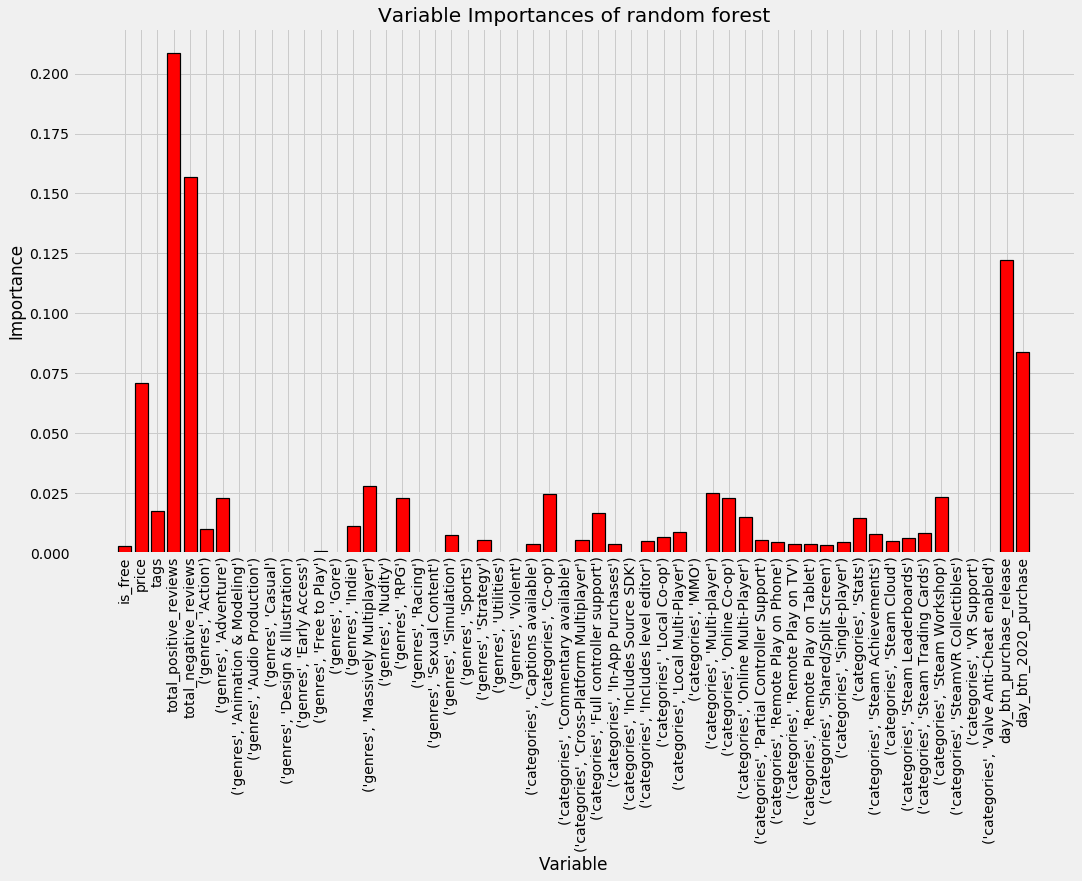

In [336]:
plt.figure(figsize=(16,9))
# Reset style 
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances of random forest');

In [361]:
mlp.fit(X, y)

TypeError: '<=' not supported between instances of 'numpy.ndarray' and 'int'

In [258]:
# Use MLP
playtime_forever = rdf.predict(test_data)
submission = pd.DataFrame(data=playtime_forever, columns=['playtime_forever'])
submission.index.name = 'id'
submission.to_csv('mlp.csv')
#16

In [259]:
# Use KNN
knn.fit(X, y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [260]:
playtime_forever = knn.predict(test_data)
submission = pd.DataFrame(data=playtime_forever, columns=['playtime_forever'])
submission.index.name = 'id'
submission.to_csv('knn.csv')
#17

In [262]:
# Use SVR
svr.fit(X, y)

/Users/jerrylee/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [263]:
playtime_forever = svr.predict(test_data)
submission = pd.DataFrame(data=playtime_forever, columns=['playtime_forever'])
submission.index.name = 'id'
submission.to_csv('svr.csv')
#19

In [340]:
# Use XGBoost
xgb.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.001, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=None, n_estimators=609,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [341]:
playtime_forever = xgb.predict(test_data)
submission = pd.DataFrame(data=playtime_forever, columns=['playtime_forever'])
submission.index.name = 'id'
submission.to_csv('xgb.csv')

In [342]:
xgb.score(X,y)

0.492737281281917

## See the features importance of random forest

In [337]:
feature_list = list(X.columns)
# Get numerical feature importances
importances = list(xgb.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
for pair in feature_importances:
    print("Variable: " + str(pair[0]) + " Importance: " + str(pair[1]))

Variable: total_positive_reviews Importance: 0.27
Variable: day_btn_purchase_release Importance: 0.17
Variable: ('genres', 'Strategy') Importance: 0.13
Variable: price Importance: 0.1
Variable: ('genres', 'Adventure') Importance: 0.07
Variable: tags Importance: 0.05
Variable: ('categories', 'Online Co-op') Importance: 0.05
Variable: total_negative_reviews Importance: 0.04
Variable: ('categories', 'Full controller support') Importance: 0.04
Variable: ('categories', 'Steam Trading Cards') Importance: 0.03
Variable: ('categories', 'In-App Purchases') Importance: 0.02
Variable: day_btn_2020_purchase Importance: 0.02
Variable: is_free Importance: 0.0
Variable: ('genres', 'Action') Importance: 0.0
Variable: ('genres', 'Animation & Modeling') Importance: 0.0
Variable: ('genres', 'Audio Production') Importance: 0.0
Variable: ('genres', 'Casual') Importance: 0.0
Variable: ('genres', 'Design & Illustration') Importance: 0.0
Variable: ('genres', 'Early Access') Importance: 0.0
Variable: ('genres'

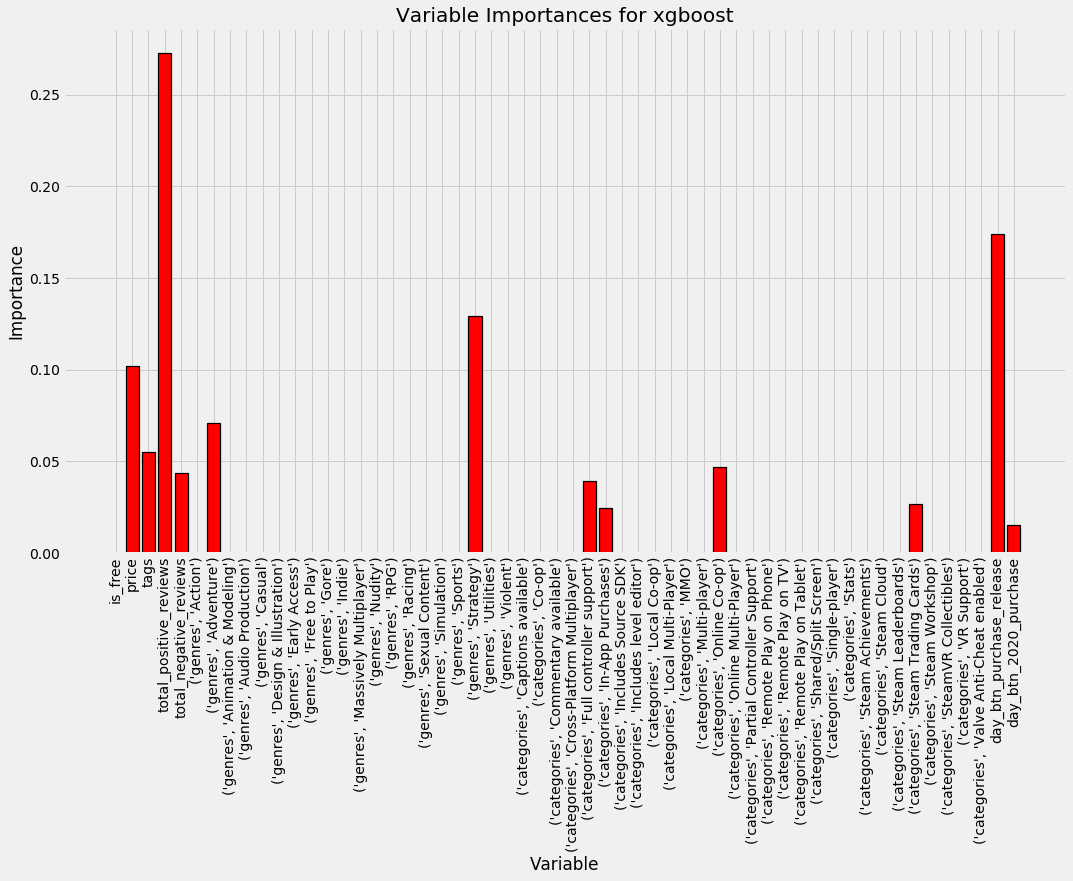

In [338]:
plt.figure(figsize=(16,9))
# Reset style 
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances for xgboost');

In [351]:
data['playtime_forever'].mean()

3.1183663833805464